In [ ]:
from google.colab import drive
import pandas as pd
import torch
from transformers import pipeline, BartTokenizer
from sentence_transformers import SentenceTransformer, util
import json
!pip install cbsodata
import cbsodata

# Mount Google Drive
drive.mount('/content/drive')

# Load embeddings (change to your drive location)
table_embeddings = torch.load('/content/drive/My Drive/table_embeddings.pt', map_location=torch.device('cpu'))
column_embeddings = torch.load('/content/drive/My Drive/column_embeddings.pt', map_location=torch.device('cpu'))

with open('/content/drive/My Drive/descriptions.json', 'r') as f:
    descriptions = json.load(f)

with open('/content/drive/My Drive/table_to_column_mapping.json', 'r') as f:
    table_to_column_mapping = json.load(f)

# Ensure all tensors are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the summarizer and sentence transformer
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)
embedding_model = SentenceTransformer('paraphrase-MiniLM-L6-v2').to(device)

Mounted at /content/drive


<ipython-input-1-eee5857503ce>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  table_embeddings = torch.load('/content/drive/My Drive/table_embeddings.pt', map_location=to

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:

# Function to find best matching tables using table embeddings
def find_best_matching_tables(query, table_embeddings, descriptions, top_k=5):
    # Embed the user query and move to the same device
    query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

    # Ensure table embeddings are on the same device
    table_vectors = [t["embedding"].to(device) for t in table_embeddings]
    table_tensor = torch.stack(table_vectors)

    # Compute cosine similarity between query and table embeddings
    cosine_scores = util.pytorch_cos_sim(query_embedding, table_tensor).squeeze()

    # Retrieve top-k matching tables
    top_k_indices = torch.topk(cosine_scores, k=top_k).indices.tolist()
    top_k_scores = torch.topk(cosine_scores, k=top_k).values.tolist()
    top_k_tables = [table_embeddings[i]["table_id"] for i in top_k_indices]

    # Retrieve the corresponding descriptions
    top_k_descriptions = [desc for desc in descriptions if desc["Identifier"] in top_k_tables]

    # Return top-k results with descriptions
    return [
        {
            "table_id": table_id,
            "score": score,
            "table_title": next(desc["table_title"] for desc in top_k_descriptions if desc["Identifier"] == table_id),
            "summary": next(desc["table_description"] for desc in top_k_descriptions if desc["Identifier"] == table_id),
        }
        for table_id, score in zip(top_k_tables, top_k_scores)
    ]

# Function to find best matching tables using column embeddings
def find_best_matching_tables_from_columns(query, column_embeddings, descriptions, table_to_column_mapping, top_k=5):
    # Embed the user query and move to the same device
    query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

    # Compute cosine similarity between query and column embeddings for each table
    table_scores = []
    for table in column_embeddings:
        table_id = table["table_id"]
        column_embeddings_tensor = table["column_embeddings"].to(device)  # Move column embeddings to the same device
        cosine_scores = util.pytorch_cos_sim(query_embedding, column_embeddings_tensor).squeeze()

        # Use the maximum score among all columns of the table
        max_score = torch.max(cosine_scores).item()
        table_scores.append({"table_id": table_id, "score": max_score})

    # Sort by score and get top-k tables
    top_k_results = sorted(table_scores, key=lambda x: x["score"], reverse=True)[:top_k]

    # Retrieve the corresponding descriptions and column titles
    top_k_descriptions = [desc for desc in descriptions if desc["Identifier"] in [r["table_id"] for r in top_k_results]]

    return [
        {
            "table_id": result["table_id"],
            "score": result["score"],
            "table_title": next(desc["table_title"] for desc in top_k_descriptions if desc["Identifier"] == result["table_id"]),
            "summary": next(desc["table_description"] for desc in top_k_descriptions if desc["Identifier"] == result["table_id"]),
            "columns": table_to_column_mapping.get(result["table_id"], []),  # Get column titles
        }
        for result in top_k_results
    ]

# Example usage
query = "How do the educational levels of the unemployed population in 2008 differ from those in 2022?"

# Find top matches using table embeddings
top_tables_from_descriptions = find_best_matching_tables(query, table_embeddings, descriptions)

# Find top matches using column embeddings
top_tables_from_columns = find_best_matching_tables_from_columns(query, column_embeddings, descriptions, table_to_column_mapping)

# Display results
print("Top Matching Tables (from descriptions):")
for result in top_tables_from_descriptions:
    print(f"Table ID: {result['table_id']}, Score: {result['score']:.4f}")
    print(f"Table Title: {result['table_title']}")
    print(f"Summary: {result['summary']}\n")

print("Top Matching Tables (from columns):")
for result in top_tables_from_columns:
    print(f"Table ID: {result['table_id']}, Score: {result['score']:.4f}")
    print(f"Table Title: {result['table_title']}")
    print(f"Summary: {result['summary']}")
    print(f"Columns: {', '.join(result['columns'])}\n")


Top Matching Tables (from descriptions):
Table ID: 82807ENG, Score: 0.5215
Table Title: Employed labour force; economic activity (SIC 2008), 2003-2022
Summary: This table contains quarterly and yearly figures on the economic activities where people work. The population of 15 to 74 years of age (excluding the institutionalized population) in paid employment is classified according to the Standard Industrial Classification (SIC 2008). A division by sex, age, level of education, professional status and working hours is available.

Due to changes in the survey design and the questionnaire of the Labour Force Survey (LFS), a revision of the figures for 2021 was carried out in the first quarter of 2022. 
As a result, the numbers of 2021 and later will not be comparable to the years 2003-2020.

Data available for 2003-2022

Status of the figures:
The figures in this table are final. 

Changes as of August 17, 2022:
None, the table has been discontinued.

From 2021 onwards the categories ‘Empl

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
!pip install umap-learn
import umap.umap_ as umap  # UMAP for non-linear dimensionality reduction
from sklearn.preprocessing import normalize

# Prepare embeddings for clustering
# Extract table embeddings only
table_embeddings_list = normalize(np.array([t["embedding"].cpu().numpy() for t in table_embeddings]))

# Dimensionality reduction
reduce_method = "UMAP"  # Change to "UMAP" for non-linear reduction

if reduce_method == "PCA":
    # Reduce dimensionality with PCA
    n_components = 30  # Choose a smaller number of dimensions
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(table_embeddings_list)
    print(f"PCA Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
elif reduce_method == "UMAP":
    # Reduce dimensionality with UMAP
    n_components = 100  # Choose a smaller number of dimensions
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', n_components=n_components)
    reduced_embeddings = reducer.fit_transform(table_embeddings_list)
else:
    raise ValueError("Unknown dimensionality reduction method. Use 'PCA' or 'UMAP'.")

# Perform DBSCAN clustering
eps = 2  # Maximum distance between two samples to be considered neighbors
min_samples = 5  # Minimum number of samples in a neighborhood to form a cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')  # Adjust metric if needed
dbscan_labels = dbscan.fit_predict(reduced_embeddings)

# Check number of clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Exclude noise (-1 label)
n_noise = list(dbscan_labels).count(-1)  # Count noise points
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Calculate silhouette score (only for clusters, excluding noise)
if n_clusters > 1:  # Silhouette score requires at least 2 clusters
    silhouette_avg = silhouette_score(
        reduced_embeddings[dbscan_labels != -1],  # Exclude noise points
        dbscan_labels[dbscan_labels != -1]
    )
    print(f"Silhouette Score for DBSCAN: {silhouette_avg:.4f}")
else:
    print("Silhouette Score cannot be calculated with fewer than 2 clusters.")


# Visualize clusters in 2D using PCA
'''
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Separate embeddings and labels for tables and columns
num_table_embeddings = len(table_embeddings_list)
table_reduced = reduced_embeddings[:num_table_embeddings]
column_reduced = reduced_embeddings[num_table_embeddings:]

table_cluster_labels = cluster_labels[:num_table_embeddings]
column_cluster_labels = cluster_labels[num_table_embeddings:]

# Plot clusters for tables
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_points = table_reduced[table_cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title('K-Means Clustering for Table Embeddings')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid()
plt.show()

# Plot clusters for columns
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_points = column_reduced[column_cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title('K-Means Clustering for Column Embeddings')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.grid()
plt.show()'''

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters: 1
Number of noise points: 0
Silhouette Score cannot be calculated with fewer than 2 clusters.


'# Visualize clusters in 2D using PCA\npca = PCA(n_components=2)\nreduced_embeddings = pca.fit_transform(all_embeddings)\n\n# Separate embeddings and labels for tables and columns\nnum_table_embeddings = len(table_embeddings_list)\ntable_reduced = reduced_embeddings[:num_table_embeddings]\ncolumn_reduced = reduced_embeddings[num_table_embeddings:]\n\ntable_cluster_labels = cluster_labels[:num_table_embeddings]\ncolumn_cluster_labels = cluster_labels[num_table_embeddings:]\n\n# Plot clusters for tables\nplt.figure(figsize=(10, 6))\nfor cluster in range(n_clusters):\n    cluster_points = table_reduced[table_cluster_labels == cluster]\n    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")\n\nplt.title(\'K-Means Clustering for Table Embeddings\')\nplt.xlabel(\'PCA Dimension 1\')\nplt.ylabel(\'PCA Dimension 2\')\nplt.legend()\nplt.grid()\nplt.show()\n\n# Plot clusters for columns\nplt.figure(figsize=(10, 6))\nfor cluster in range(n_clusters):\n    cluster_p

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
!pip install umap-learn
import umap.umap_ as umap

# Prepare embeddings
table_ids = [table["table_id"] for table in table_embeddings]
table_vectors = np.array([table["embedding"].cpu().numpy() for table in table_embeddings])
column_vectors = np.array([col for table in column_embeddings for col in table["column_embeddings"]])
all_vectors = np.vstack([table_vectors, column_vectors])

# Normalize embeddings
scaler = StandardScaler()
normalized_vectors = scaler.fit_transform(all_vectors)

# Reduce dimensionality with UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(normalized_vectors)

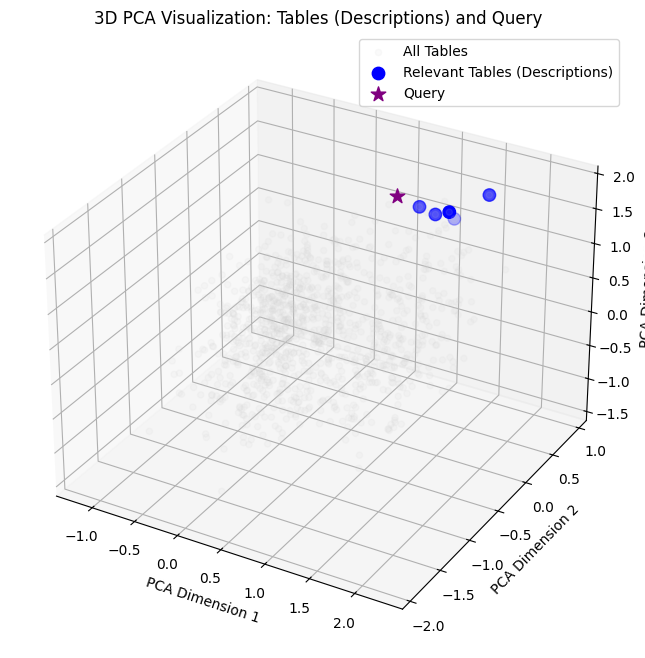

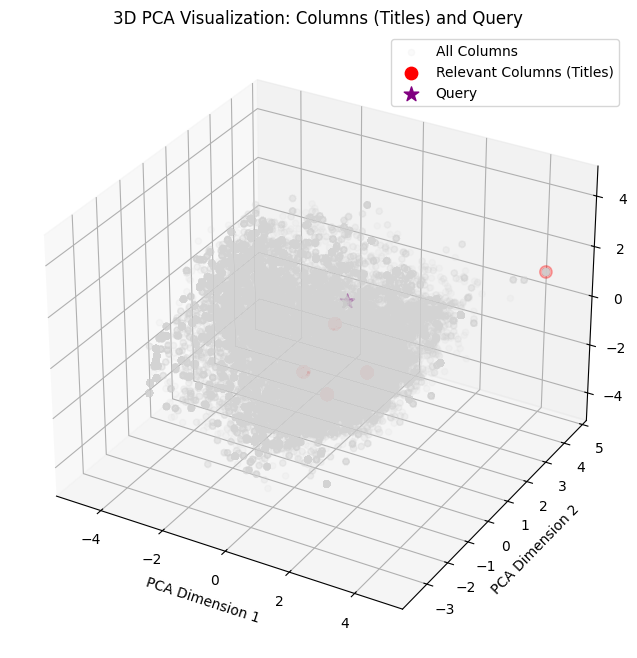

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torch

# Prepare embeddings for PCA
table_ids = [table["table_id"] for table in table_embeddings]
table_vectors = np.array([table["embedding"].cpu().numpy() for table in table_embeddings])
column_vectors = np.array([col for table in column_embeddings for col in table["column_embeddings"]])

# Combine table and column embeddings for PCA
all_vectors = np.vstack([table_vectors, column_vectors])
pca = PCA(n_components=3)
pca_3d = pca.fit_transform(all_vectors)

# Split PCA results for tables and columns
table_3d = pca_3d[:len(table_vectors)]
column_3d = pca_3d[len(table_vectors):]

# Extract indices of the 5 most relevant tables and columns
top_table_indices = [table_ids.index(t["table_id"]) for t in top_tables_from_descriptions[:5]]

# Extract top 5 column indices (sorted by similarity scores)
top_column_indices = []
for t in top_tables_from_columns[:5]:
    table_id = t["table_id"]
    column_start_idx = sum(len(c["column_embeddings"]) for c in column_embeddings[:table_ids.index(table_id)])
    top_column_indices.extend(list(range(column_start_idx, column_start_idx + len(column_embeddings[table_ids.index(table_id)]["column_embeddings"]))))

top_column_indices = top_column_indices[:5]  # Limit to top 5 columns

# Plot 3D visualization for tables derived from descriptions
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all tables in very light grey (almost transparent)
ax.scatter(table_3d[:, 0], table_3d[:, 1], table_3d[:, 2], c='lightgrey', label='All Tables', alpha=0.1)

# Highlight the most relevant tables in blue
ax.scatter(
    table_3d[top_table_indices, 0],
    table_3d[top_table_indices, 1],
    table_3d[top_table_indices, 2],
    c='blue',
    label='Relevant Tables (Descriptions)',
    s=80
)

# Add query point
query_embedding = embedding_model.encode(query, convert_to_tensor=True).cpu().numpy()
query_3d = pca.transform(query_embedding.reshape(1, -1))
ax.scatter(query_3d[0, 0], query_3d[0, 1], query_3d[0, 2], c='purple', label='Query', s=120, marker='*')

ax.set_title('3D PCA Visualization: Tables (Descriptions) and Query')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend()
plt.show()

# Plot 3D visualization for columns derived from titles
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all columns in very light grey (almost transparent)
ax.scatter(column_3d[:, 0], column_3d[:, 1], column_3d[:, 2], c='lightgrey', label='All Columns', alpha=0.1)

# Highlight the most relevant columns in green
highlighted_columns = column_3d[top_column_indices]
ax.scatter(
    highlighted_columns[:, 0],
    highlighted_columns[:, 1],
    highlighted_columns[:, 2],
    c='red',
    label='Relevant Columns (Titles)',
    s=80
)

# Add query point
ax.scatter(query_3d[0, 0], query_3d[0, 1], query_3d[0, 2], c='purple', label='Query', s=120, marker='*')

ax.set_title('3D PCA Visualization: Columns (Titles) and Query')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare embeddings
table_ids = [table["table_id"] for table in table_embeddings]
table_vectors = torch.stack([table["embedding"] for table in table_embeddings]).to(device)
column_vectors = torch.cat([table["column_embeddings"] for table in column_embeddings]).to(device)
all_vectors = torch.cat([table_vectors, column_vectors])

# Normalize embeddings (on GPU using PyTorch)
scaler = StandardScaler()
all_vectors_np = all_vectors.cpu().numpy()  # Convert to NumPy for scaler
normalized_vectors = scaler.fit_transform(all_vectors_np)
normalized_vectors_tensor = torch.tensor(normalized_vectors).to(device)

# Reduce dimensionality with CPU-based t-SNE
reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, metric="cosine", random_state=42)
embedding_2d = reducer.fit_transform(normalized_vectors_tensor.cpu().numpy())  # t-SNE expects NumPy input

# Split reduced embeddings for tables and columns
table_2d = embedding_2d[:len(table_vectors)].cpu().numpy()
column_2d = embedding_2d[len(table_vectors):].cpu().numpy()

# Plot the top 5 closest tables from descriptions
top_table_indices = [table_ids.index(t["table_id"]) for t in top_tables_from_descriptions[:5]]
plt.scatter(
    table_2d[top_table_indices, 0],
    table_2d[top_table_indices, 1],
    c='blue',
    label='Closest Tables (Descriptions)',
    alpha=0.7,
    s=80
)

# Plot the top 5 closest tables from columns
top_column_table_ids = [t["table_id"] for t in top_tables_from_columns[:5]]
top_column_indices = [table_ids.index(tid) for tid in top_column_table_ids]
plt.scatter(
    table_2d[top_column_indices, 0],
    table_2d[top_column_indices, 1],
    c='green',
    label='Closest Tables (Columns)',
    alpha=0.7,
    s=80
)

# Embed the query and transform it into t-SNE space
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)
query_embedding_np = query_embedding.cpu().numpy()
query_embedding_normalized = scaler.transform([query_embedding_np])  # Normalize the query embedding
query_2d = reducer.fit_transform(np.vstack([normalized_vectors, query_embedding_normalized]))[-1]

# Plot the query embedding
plt.scatter(
    query_2d[0],
    query_2d[1],
    c='purple',
    label='Query',
    s=120,
    marker='*'
)

# Annotations and legend
plt.title('Embedding Visualization with t-SNE: Top Matching Tables, Columns, and Query')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid()
plt.show()


Using device: cuda


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

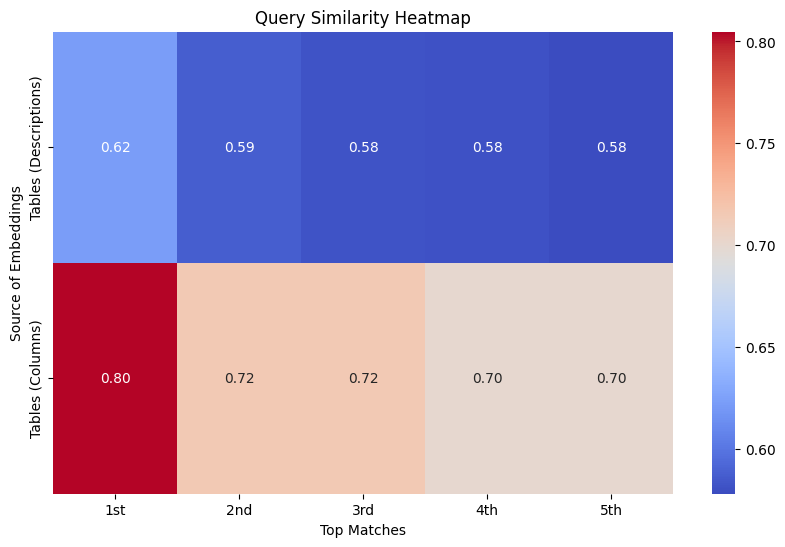

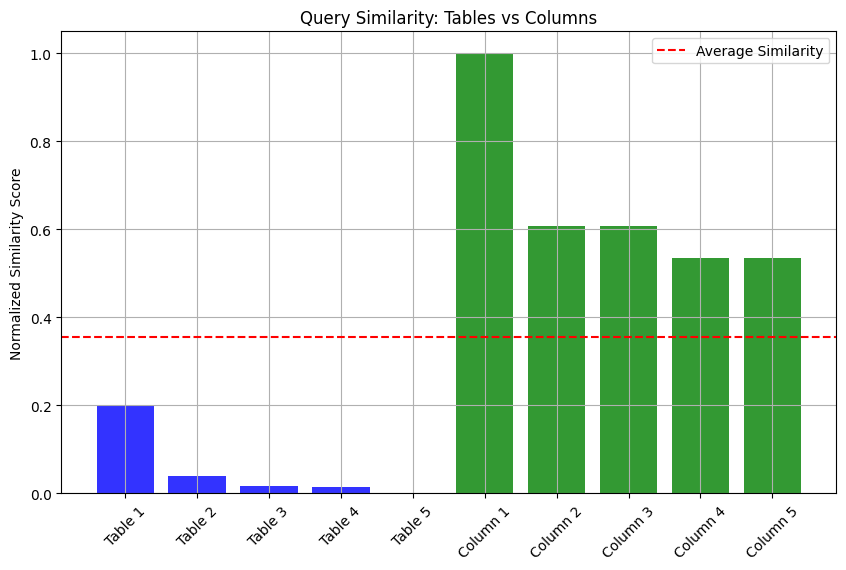

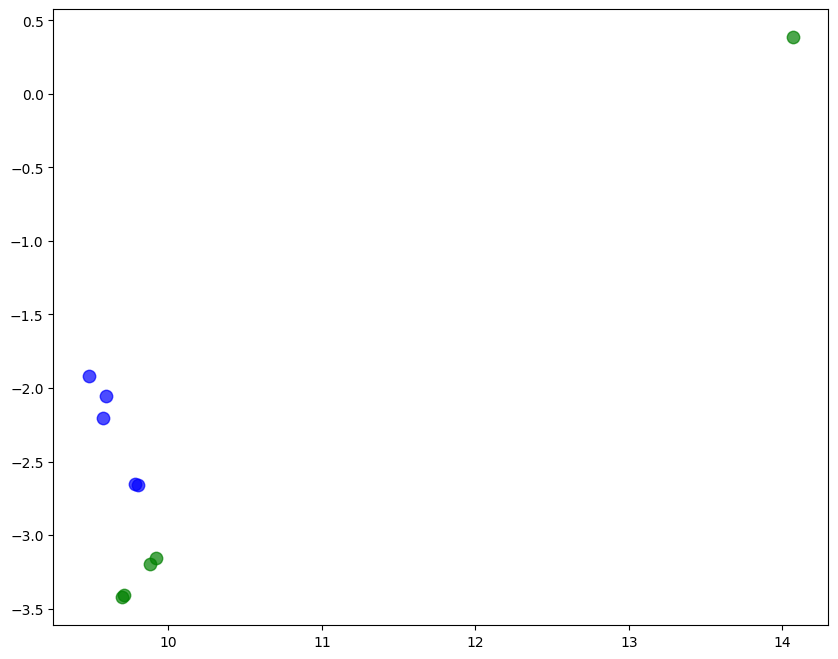

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare cosine similarity data for heatmaps
table_scores = [t["score"] for t in top_tables_from_descriptions[:5]]
column_scores = [t["score"] for t in top_tables_from_columns[:5]]
table_titles = [t["table_title"] for t in top_tables_from_descriptions[:5]]
column_titles = [t["table_title"] for t in top_tables_from_columns[:5]]

# Normalize scores for comparison
all_scores = table_scores + column_scores
normalized_scores = (np.array(all_scores) - np.min(all_scores)) / (np.max(all_scores) - np.min(all_scores))

# Split normalized scores
normalized_table_scores = normalized_scores[:len(table_scores)]
normalized_column_scores = normalized_scores[len(table_scores):]

# Heatmap of query similarity
plt.figure(figsize=(10, 6))
heatmap_data = np.array([table_scores, column_scores])
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=["1st", "2nd", "3rd", "4th", "5th"],
    yticklabels=["Tables (Descriptions)", "Tables (Columns)"]
)
plt.title("Query Similarity Heatmap")
plt.xlabel("Top Matches")
plt.ylabel("Source of Embeddings")
plt.show()
# Ensure that we are using the correct top 5 table and column scores
table_scores = [t["score"] for t in top_tables_from_descriptions[:5]]
column_scores = [t["score"] for t in top_tables_from_columns[:5]]

# Normalize scores for comparison
all_scores = table_scores + column_scores
normalized_scores = (np.array(all_scores) - np.min(all_scores)) / (np.max(all_scores) - np.min(all_scores))

# Create x_labels and colors corresponding to the scores
x_labels = [f"Table {i+1}" for i in range(len(table_scores))] + [f"Column {i+1}" for i in range(len(column_scores))]
colors = ["blue"] * len(table_scores) + ["green"] * len(column_scores)

# Bar chart comparison of normalized scores
plt.figure(figsize=(10, 6))
plt.bar(x_labels, normalized_scores, color=colors, alpha=0.8)
plt.axhline(y=np.mean(normalized_scores), color="red", linestyle="--", label="Average Similarity")
plt.xticks(rotation=45)
plt.title("Query Similarity: Tables vs Columns")
plt.ylabel("Normalized Similarity Score")
plt.legend()
plt.grid()
plt.show()


# Scatter plot visualization with query embedding
plt.figure(figsize=(10, 8))

# Plot top 5 tables from descriptions
plt.scatter(
    table_2d[top_table_indices, 0],
    table_2d[top_table_indices, 1],
    c='blue',
    label='Closest Tables (Descriptions)',
    alpha=0.7,
    s=80
)

# Plot top 5 tables from columns
plt.scatter(
    table_2d[top_column_indices, 0],
    table_2d[top_column_indices, 1],
    c='green',
    label='Closest Tables (Columns)',
    alpha=0.7,
    s=80
)

# Embed the query and transform it into UMAP space
query_embedding = embedding_model.encode(query, convert_to_tensor=True).cpu().numpy()
query_embedding_normalized = scaler.transform([query_embedding])  # Normalize the query embedd


In [ ]:
print(f"Number of tables plotted: {len(top_table_indices)}")


Number of tables plotted: 3
